In [6]:
import numpy as np
import matplotlib.pyplot as plt
import nengo
from nengo.utils.ensemble import tuning_curves
from nengo.utils.matplotlib import rasterplot

# Izhikevich Neuron Model

This notebook will compare the Izikhevich neuron model for single and groups of neurons implemented in matlab/python compared to using Nengo, a python package for building/testing/deploying neural networks, and nengo Loihi, a backend for running Nengo models on Intel’s Loihi architecture

Model single neuron initially: normally vs. nengo
then small number of neurons with adjacency matrix: normal v nengo


* Track v, u, (and I as well?) for different parameters of model
* firing rate
* Deterministic input versus noise for I

### todo/to ask: 
   * figure out how nengo inputs current (maybe use processes?: https://www.nengo.ai/nengo/examples/advanced/processes.html)
    * understand why changing the encoder allowed the nengo single neuron to work (when it was its default value instead of 1, gave weird results)
    * figure out how to change nengo's current to noise or piecewise step
    * is the way I'm implementing noise ok? Matlab way for multiple neurons seemed like input was low



### helpful links:
documentation for different neuron types: https://www.nengo.ai/nengo/_modules/nengo/neurons.html

documentation for simulator: https://www.nengo.ai/nengo/_modules/nengo/simulator.html


can i change J in Nengo?

    J : ndarray
        a vector of currents to generate firing rates from
    *states : list of ndarrays
    

In [171]:
########################################################################
# SINGLE NEURON - non-nengo version
#######################################################################

# changing a, b, c, and d results in various intrinsic firing patterns

def normal_izhik(a=.02, b=.20, c=-65, d=6, dt=.2, time=100, current = 'step', noise = True, I = 50):
    '''inputs a, b, c, and d, and returns plots of voltage v, recovery 
    variable u, and current input'''
    # how much output do you want to see * add so you can see only a fraction of the time points
    
    # a, b, c, d are the parameters of the Izhikevich model.
    # a: the time scale of the recovery variable
    # b: the sensitivity of the recovery variable
    # c: the after-spike reset value of the membrane potential
    # d: after-spike reset of the recovery variable
    
    # v: membrane potential of the neuron
    # u: membrane recovery variable (K+ and Na+ ionic currents)
    # I: synaptic currents or injected dc currents
        # three versions: 
          # 'step' = dc current - steps up to what is defined in 'step', default 50 mV
          # 'constant' 50 mV (with/without noise) experiment to see how high needs to be
          # 'time_dep' - sine wave, but does it have to be centered higher?
        # noise: If noise = True, adds gaussian noise (np.random.random)
    
    
    
    # set up time 
    N = int(time/dt)             # total number of points desired
    tMax = time                  # max time (ms)
    
    t = np.linspace(0, tMax, N)  # Nx1 array with timepoints
    num_steps = len(t)
    dt = t[1] - t[0]             # one time step, dt is tMax/N
    
    
    # set up membrane potential (v) and recovery variable (u) arrays:
    v = np.zeros((N, 1))
    u = np.zeros((N, 1))
    vM = np.zeros((N ,1))    # used to visualize spikes (think about this)
    fired = []
    
    # set up current
    Iext = np.zeros((N, 1) )

    if current == 'constant':
        Iext += I
        
    elif current == 'time_dep':
        Iext += I * np.sin(2 * np.pi * t).reshape(N, 1)   # deterministic current injection, causes voltage response
        
    if current == 'step':
        Iext[int(N/10):] = I         # after a tenth of the total time, increase current (piecewise)
    
    if noise == True:
        Iext += 3 * np.random.randn(N, 1) # use this for noisy input

        
    # initialize
    v[0] = -65
    u[0] = b * v[0]
    
    for i in range(0, N-1):
        # update membrane potential
        v[i+1] = v[i] + 0.5 * dt * (.04 * v[i]**2 + 5 * v[i] + 140 - u[i] + Iext[i])
        v[i+1] +=  0.5 * dt * (.04 * v[i]**2 + 5 * v[i] + 140 - u[i] + Iext[i])

        u[i+1] = u[i] + dt * a * (b * v[i] - u[i])
        
        # if neuron reaches threshold, apply after-spike setting
        if v[i+1] > 30:
            v[i+1] = c
            u[i+1] += d
            fired.append((i+1) * dt)

            # vM[i+1] = 30
        else:
            vM[i+1] = v[i+1]
    print('dt: {}'.format(dt))
    print('number of steps: {}'.format(num_steps))
            
    return t, v, u, Iext, fired

def plot_results(t, v, u, Iext, fired):
    
    plt.figure(figsize = (20,7))

    plt.subplot(411)
    plt.plot(t,v)
    plt.ylabel("voltage v")
    
    
    plt.subplot(412)
    plt.plot(t, u)
    plt.ylabel("recovery variable u")
    plt.xlabel("time(ms)")
    
    plt.subplot(413)
    plt.plot(t,Iext)
    plt.ylabel("current input I")
    plt.xlabel("time(ms)")
    
    plt.subplot(414)
    plt.eventplot(fired)
    plt.ylabel("spikes I")
    plt.xlabel("time(ms)")


    
    
            

## Thoughts:

Trying to clarify how current works:
Have a constant background current (50?), and add random noise for each step for a single neuron. Does this seem to change the spiking at all?

Making background current a sine wave? Simulate synaptic inputs with noisy input for each step. 



What magnitude does background noise have to have in order for spikes to occur? In the matlab code, the noise is ` retinaParams(i).I = [3*randn(totNeurons_Retina,1)] `, and each additional current input comes fom summing the rows of the connectivity matrix for neurons that fired. In the single neuron case, we just add noise each step simulating that connection. But the connections are still less than 10 in each case, doesn't seem like much but with the other terms, adds up to let neurons fire

For the single neuron, I need a certain level of background current in order for spiking to happen. Higher than the matlab code. Why would this be?

What would be the difference between clean signal + noise, like having 50mV + Gaussian noise, versus Gaussian noise multiplied by 50? 
`50 * np.random.random()` 
**What magnitude of noise makes a difference?** If the amplitude is too high, is the signal lost? (Like if you multiplied noise by too high of a value)

#### First, comparing step current with and without noise

dt: 0.20040080160320642
number of steps: 500


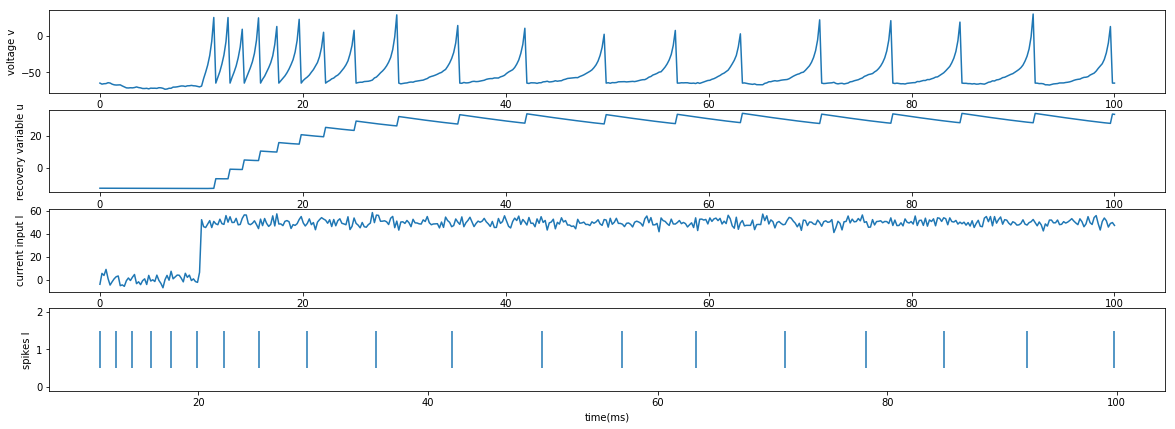

In [172]:
plot_results(*normal_izhik(dt = .2, current = 'step') )

dt: 0.20040080160320642
number of steps: 500


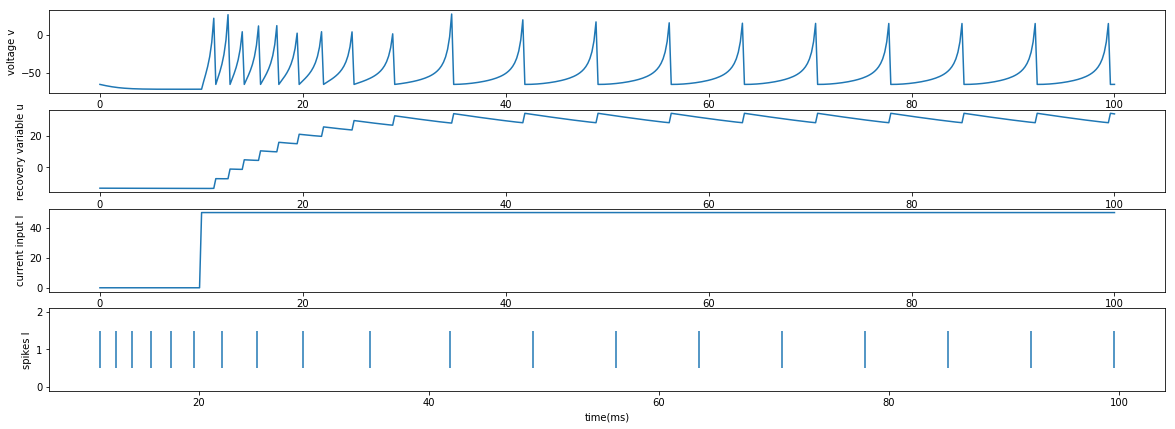

In [173]:
plot_results(*normal_izhik(dt=.2, time = 100, current = 'step', noise = False))

### Now see how different centering of current affects spikes

dt: 0.20040080160320642
number of steps: 500
dt: 0.20040080160320642
number of steps: 500


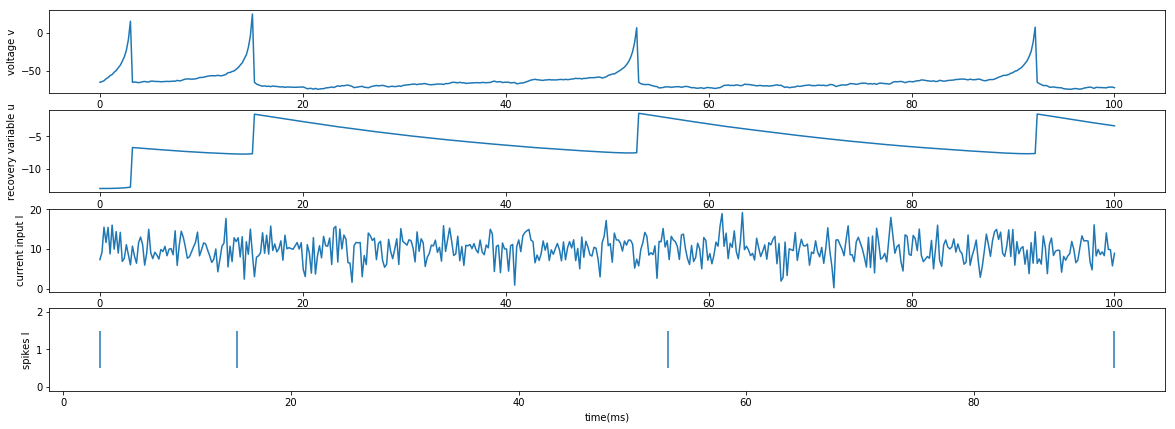

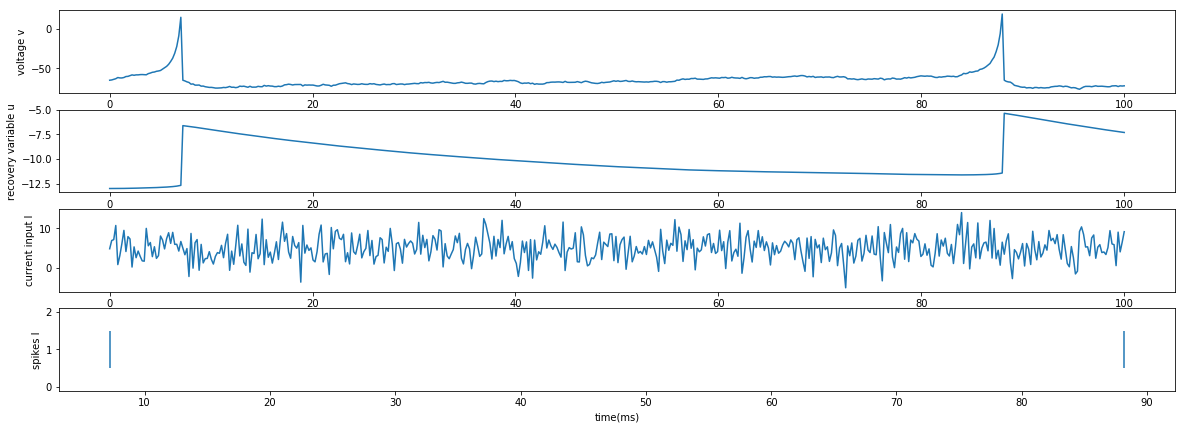

In [174]:
# comparing two models where only difference is level of background current
plot_results(*normal_izhik(current = 'constant', I=10)) 
plot_results(*normal_izhik(current = 'constant', I=5)) 

### Now see what happens when time step changes

dt: 1.0101010101010102
number of steps: 100


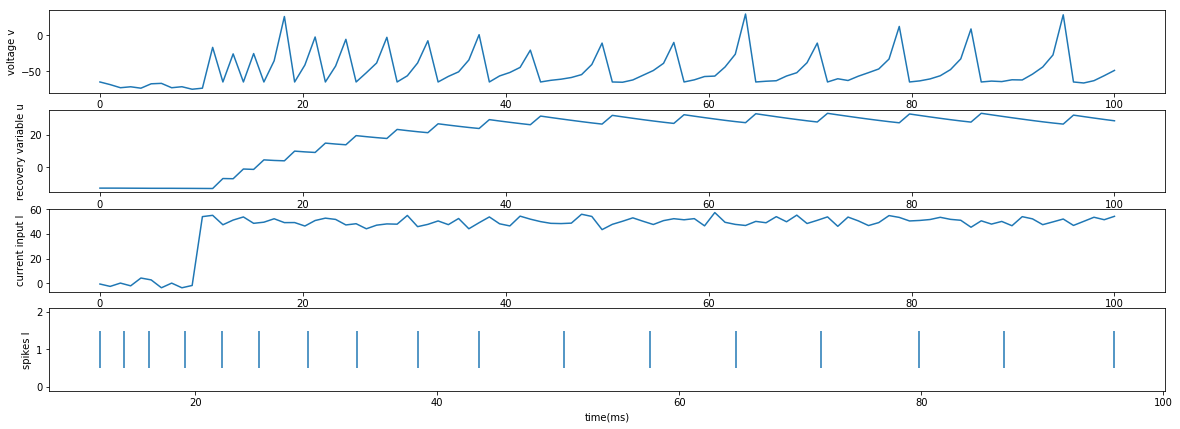

In [175]:
plot_results(*normal_izhik(time = 100, dt = 1)) # looking at what happens for large relative timestep

### Now see whether changing parameter values changes spiking patterns

dt: 0.020004000800160033
number of steps: 5000


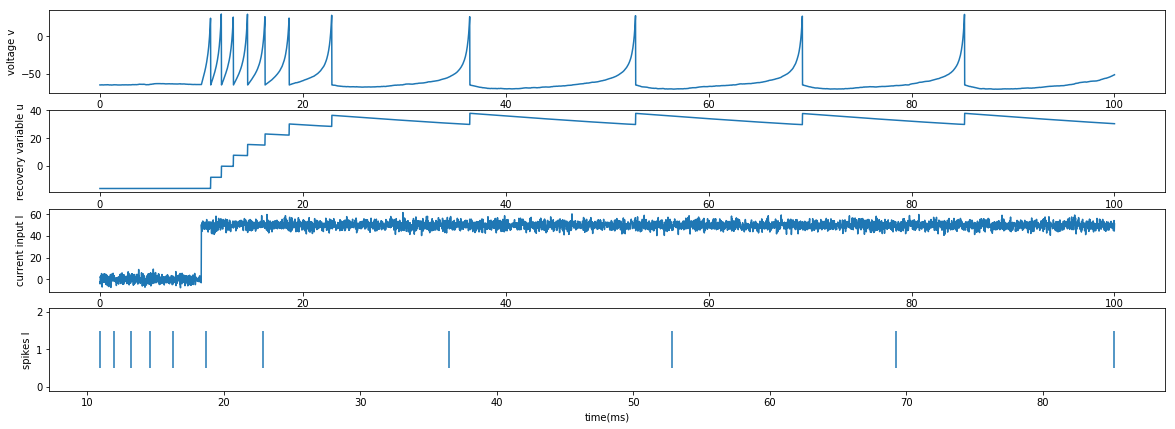

In [176]:
# phasic spiking
plot_results(*normal_izhik(a=.01, b=.25, c=-65, d=8, time = 100, dt = .02))

dt: 0.20040080160320642
number of steps: 500


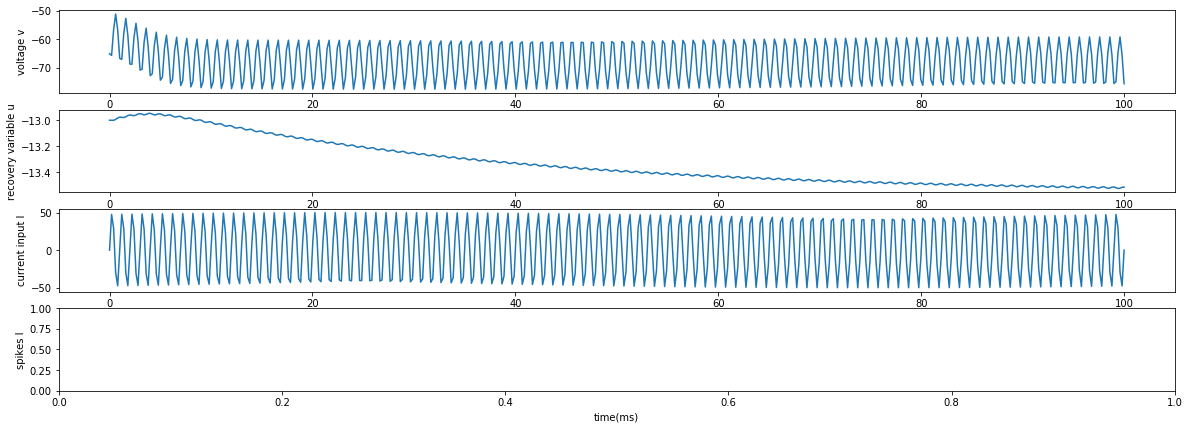

In [177]:
plot_results(*normal_izhik(current = 'time_dep', noise = False)) # is sinusoidal input current even important?

# Nengo

Now we will implement a single Izhikevich neuron in Nengo. The greatest challenge is determining how to change the desired current input. Is adding a connection between a node with a function and the ensemble of neurons going to change their input current, or what the neurons' output is supposed to represent? Or are those the same? Can we explicitly change J, the array of current? Can we use processes to change the current?

**differences**
* timing seems different. default is .001 as time step in simulation. same time parameters gives different spiking
* "step" current, at least the way I am implementing it, doesn't seem to give the same spiking as it does in matlab version. Maybe
____

note: after putting in encoders = [[1]], the spikes became visible spikes rather than weird nonsense. Did this because the single neuron model for LIF on their website did it. Neurons in the ensemble with encoder of 1 pick up positive current, -1 picks up negative current.

From Izhikevich implentation in Nengo for multiple neurons (https://www.nengo.ai/nengo/examples/advanced/izhikevich.html):

Those neurons that have an encoder of -1 receive negative current, and therefore remain at a low voltage.

Those neurons that have an encoder of 1 receive positive current, and start spiking rapidly. However, as they spike, the recovery variable grows, until it reaches a balance with the voltage such that the cells spike regularly.

This occurs because, by default, we use a set of parameters that models a “regular spiking” neuron. We can use parameters that model several different classes of neurons instead
___

In source code for nengo.ensemble (https://www.nengo.ai/nengo/_modules/nengo/ensemble.html):

`
    encoders : Distribution or (n_neurons, dimensions) array_like, optional
        The encoders used to transform from representational space
        to neuron space. Each row is a neuron's encoder; each column is a
        representational dimension.`

`    noise : Process, optional
        Random noise injected directly into each neuron in the ensemble
        as current. A sample is drawn for each individual neuron on
        every simulation step.`

First, we need to figure out how to input current in Nengo, or at least, how they input current in Nengo. For a single neuron, it seems we can input Noise as current using Processes. However, simply switching the neuron_type into an Izhikevich neuron doesn't let it spike properly. Similar to the problem I had above, perhaps spiking will happen at only noise input for multi-neurons. Is there a way to apply the noise to a constant input?

In [443]:
time = .15
dt = .001
std = .1

def compare(time, dt, std):
    ''' compare the spiking of an LIF neuron with an Izhikevich neuron 
    with and without Gaussian noise of given std, mean at 0 for given
    simulation time and time step duration'''
    
    process = nengo.processes.WhiteNoise(
        dist=nengo.dists.Gaussian(0, std), seed=1)
    
    with nengo.Network() as model:
        ens_args = dict(encoders=[[1]], intercepts=[0.01], max_rates=[100]) # what do these mean
        a = nengo.Ensemble(1, 1, **ens_args)
        b = nengo.Ensemble(1, 1, noise=process, **ens_args)
        c = nengo.Ensemble(1, 1, noise=process, **ens_args, neuron_type = nengo.Izhikevich())
        d = nengo.Ensemble(1, 1, **ens_args, neuron_type = nengo.Izhikevich())
    
        a_voltage = nengo.Probe(a.neurons, 'voltage')
        b_voltage = nengo.Probe(b.neurons, 'voltage')
        c_voltage = nengo.Probe(c.neurons, 'voltage')
        c_recovery = nengo.Probe(c.neurons, 'recovery')
        d_voltage = nengo.Probe(d.neurons, 'voltage')
    
    with nengo.Simulator(model, dt = dt) as sim:
        sim.run(time)
    
    plt.figure()
    plt.subplot(311)
    plt.plot(sim.trange(), sim.data[a_voltage], label="LIF deterministic")
    plt.plot(sim.trange(), sim.data[b_voltage], label="LIF noisy")
    plt.xlabel('time [s]')
    plt.ylabel('voltage')
    plt.legend(loc=4);
    
    plt.subplot(312)
    plt.plot(sim.trange(), sim.data[c_voltage], label="Izhik noisy")
    plt.plot(sim.trange(), sim.data[d_voltage], label="Izhik deterministic")
    
    
    plt.xlabel('time [s]')
    plt.ylabel('voltage')
    plt.legend(loc=4);
    
    plt.subplot(313)
    plt.plot(sim.trange(), sim.data[c_recovery], label="Izhik noisy")
    plt.xlabel('time [s]')
    plt.ylabel('recovery u')
    plt.legend(loc=4);

    

Here we can see that inputting Gaussian noise as current makes spikes for LIF neurons, but not for Izhikevich neurons. Generally, why is the range of the voltage for Izhikevich hovering at resting potential? Do we need higher current?

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

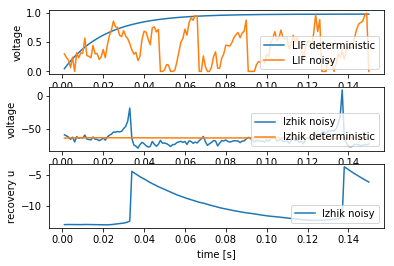

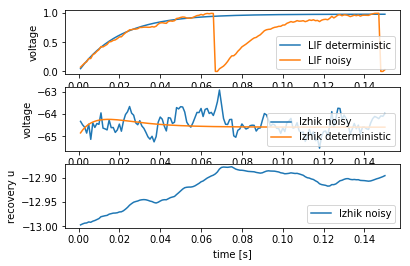

In [444]:
compare(time = .15, dt = .001, std = .1)
compare(time = .15, dt = .001, std = .01)


In [363]:
x = np.zeros((10,1))
x[5:] = 50
nengo.neurons.NeuronType.current(model, x, 1, 0) # how to get this into neurons?

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [50.],
       [50.],
       [50.],
       [50.],
       [50.]])

Now we will try to make step current like we did in the normal version, and see whether using this as input will change the spiking pattern for Izhikevich neurons.

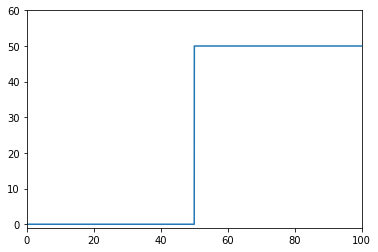

In [471]:
# make step current 

inputs = [[0], [50]]
step_current = nengo.processes.PresentInput(inputs, presentation_time=50)

tlen = 100
plt.figure()
plt.plot(step_current.trange(tlen), step_current.run(tlen))
plt.xlim([0, tlen])
plt.ylim([-1, 60]);

In [472]:
sim.data[c_voltage].shape

KeyError: <Probe at 0x11750ee10 of 'voltage' of <Neurons of <Ensemble (unlabeled) at 0x1185c9250>>>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

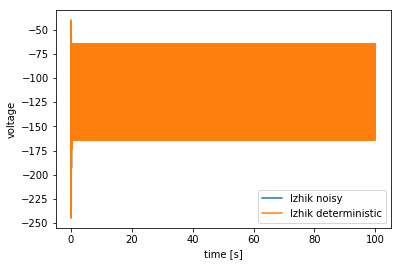

In [473]:
# use step current as noise in an example with a single neuron 
# dt is automatically .001, try different values

with nengo.Network() as model:
    ens_args = dict(encoders=[[1]], intercepts=[0.01], max_rates=[100]) # what do these mean
    a = nengo.Ensemble(1, 1, **ens_args, neuron_type = nengo.Izhikevich()) 
    b = nengo.Ensemble(1, 1, **ens_args, neuron_type = nengo.Izhikevich()) # no input

    current_node = nengo.Node(step_current)
    nengo.Connection(current_node, a)
    a_voltage = nengo.Probe(a.neurons, 'voltage')
    b_voltage = nengo.Probe(b.neurons, 'voltage')

with nengo.Simulator(model, dt = .02 ) as sim:
    sim.run(100)

plt.figure()
plt.plot(sim.trange(), sim.data[a_voltage], label="Izhik noisy")
plt.plot(sim.trange(), sim.data[b_voltage], label="Izhik deterministic")


plt.xlabel('time [s]')
plt.ylabel('voltage')
plt.legend(loc=4);


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

(100, 1)


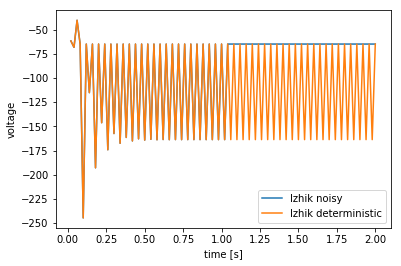

In [468]:
# use step current as noise in an example with a single neuron 
# dt is automatically .001, try different values

with nengo.Network() as model:
    ens_args = dict(encoders=[[1]], intercepts=[0.01], max_rates=[100]) # what do these mean
    c = nengo.Ensemble(1, 1, **ens_args, neuron_type = nengo.Izhikevich()) # step current input
    d = nengo.Ensemble(1, 1, **ens_args, neuron_type = nengo.Izhikevich()) # no input

    current_node = nengo.Node(step_current)
    nengo.Connection(current_node, c)
    c_voltage = nengo.Probe(c.neurons, 'voltage')
    d_voltage = nengo.Probe(d.neurons, 'voltage')

with nengo.Simulator(model, dt = .02 ) as sim:
    sim.run(2)

plt.figure()
plt.plot(sim.trange(), sim.data[c_voltage], label="Izhik noisy")
plt.plot(sim.trange(), sim.data[d_voltage], label="Izhik deterministic")


plt.xlabel('time [s]')
plt.ylabel('voltage')
plt.legend(loc=4);
print(sim.data[c_voltage].shape)

In [384]:
sim.data[u_output].shape


(2000, 1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

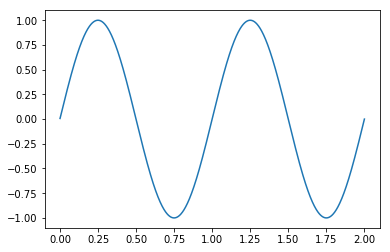

In [448]:
# Making a sine input 

with nengo.Network() as model:
    #u = nengo.Node(output=50)
    u = nengo.Node(lambda t: np.sin(np.pi * 2 * t))
    
    t = np.linspace(0,2,2000)
    u_output = nengo.Probe(u)
with nengo.Simulator(model) as sim:
    sim.run(2)

plt.plot(t, sim.data[u_output])



In [406]:
sim.data[u_output].shape

(100, 1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

Text(0, 0.5, 'voltage')

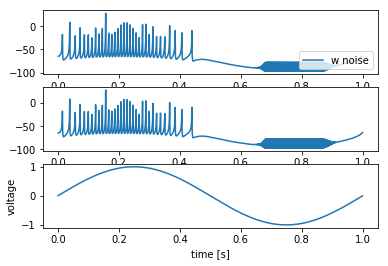

In [427]:
# use step current in an example with a single neuron

time = 1
dt = .001

with nengo.Network() as model:
    u = nengo.Node(lambda t: np.sin(np.pi * 2 * t))
    u_output = nengo.Probe(u)

    ens_args = dict(encoders=[[1]], intercepts=[0.01], max_rates=[100]) # what do these mean
    c = nengo.Ensemble(1, 1, noise=step_current, **ens_args, neuron_type = nengo.Izhikevich()) # step current input
    d = nengo.Ensemble(1, 1, **ens_args, neuron_type = nengo.Izhikevich()) # no input

    nengo.Connection(u, d)
    nengo.Connection(u, c)
    
    
    c_voltage = nengo.Probe(c.neurons, 'voltage')
    d_voltage = nengo.Probe(d.neurons, 'voltage')

with nengo.Simulator(model, dt = dt) as sim:
    sim.run(time)

plt.figure()
plt.subplot(311)
plt.plot(sim.trange(), sim.data[c_voltage], label="w noise")
plt.legend(loc=4);

plt.subplot(312)
plt.plot(sim.trange(), sim.data[d_voltage])


plt.subplot(313)
plt.plot(np.linspace(0,time,time/dt), sim.data[u_output])
plt.xlabel('time [s]')
plt.ylabel('voltage')


In [478]:
def nengo_izh(a=.02, b=.20, c=-65, d=6, dt = .001, time = 1):
    '''visualize a single neuron with Gaussian noise as current input'''
    
    with nengo.Network(seed=0) as model:
        process = nengo.processes.WhiteNoise(dist=nengo.dists.Gaussian(0, .1), seed=1)

        #u = nengo.Node(lambda t: np.sin(2 * np.pi * t))
        ens = nengo.Ensemble(1, dimensions=1, encoders = [[1]], noise = process,
                             neuron_type = nengo.Izhikevich(tau_recovery = a,
                                                          coupling = b, 
                                                          reset_voltage = c,
                                                          reset_recovery = d))
        #nengo.Connection(u, ens)
        
        #out_p = nengo.Probe(ens, synapse=0.03)

        spikes_p = nengo.Probe(ens.neurons)
        voltage_p = nengo.Probe(ens.neurons, 'voltage')
        recovery_p = nengo.Probe(ens.neurons, 'recovery')
        print(ens.noise)

        
    

    def izh_plot(sim):
        t = sim.trange()
        plt.figure(figsize=(12, 10))
        #plt.subplot(5, 1, 1)
        #plt.plot(t, sim.data[out_p])
        #plt.ylabel("Decoded output")
        #plt.xlim(right=t[-1])
        
        
        ax = plt.subplot(4, 1, 1)
        rasterplot(t, sim.data[spikes_p], ax=ax)
        plt.ylabel("Neuron")
        plt.xlim(right=t[-1])
        
        plt.subplot(4, 1, 2)
        plt.plot(t, sim.data[voltage_p])
        plt.ylabel("Voltage v")
        plt.xlim(right=t[-1])
        
        plt.subplot(4, 1, 3)
        plt.plot(t, sim.data[recovery_p])
        plt.ylabel("Recovery u")
        plt.xlim(right=t[-1])
        
        plt.subplot(4, 1, 4)
        #plt.plot(t, np.sin(2 * np.pi * t))
        plt.ylabel("noise")
        plt.xlim(right=t[-1])
        
        plt.plot(process.trange(time), process.run(time))
    



    
    with nengo.Simulator(model, dt = dt) as sim: # dt is the length of the sim timestep (s)
        sim.run(time)              # time is in seconds, run for 100ms
    izh_plot(sim)
   

WhiteNoise(Gaussian(mean=0, std=0.1), scale=True)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

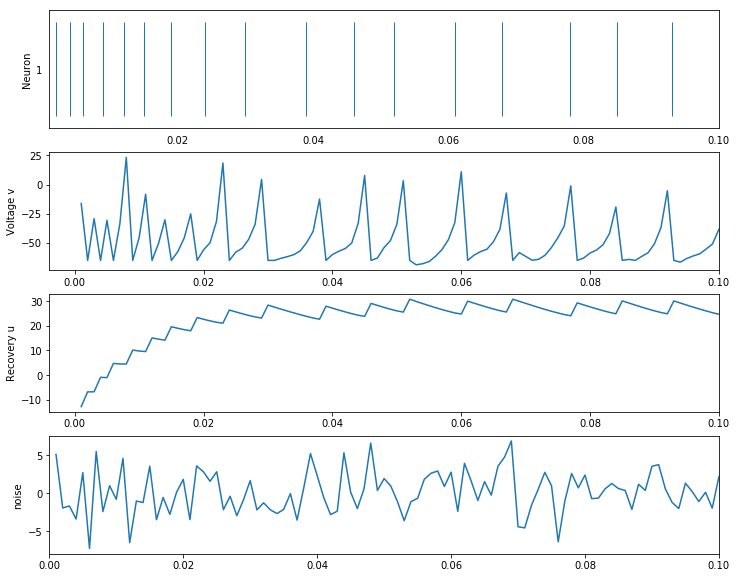

In [479]:
nengo_izh(time = .1, dt = .001)

In [358]:
nengo.dists.Gaussian?

Init signature: nengo.dists.Gaussian(mean, std)
Docstring:     
A Gaussian distribution.

This represents a bell-curve centred at ``mean`` and with
spread represented by the standard deviation, ``std``.

Parameters
----------
mean : Number
    The mean of the Gaussian.
std : Number
    The standard deviation of the Gaussian.

Raises
------
ValidationError if std is <= 0
File:           ~/anaconda3/lib/python3.7/site-packages/nengo/dists.py
Type:           type
Subclasses:     


In [485]:
def nengo_izh(a=.02, b=.20, c=-65, d=6, dt = .001, time = 1):
    '''visualize a single izhikevich neuron using nengo. Sine input current'''
    
    with nengo.Network(seed=0) as model:
        #process = nengo.processes.WhiteNoise(dist=nengo.dists.Gaussian(0, .1), seed=1)

        u = nengo.Node(lambda t: np.sin(2 * np.pi * t))
        ens = nengo.Ensemble(1, dimensions=1, encoders = [[1]],
                             neuron_type = nengo.Izhikevich(tau_recovery = a,
                                                          coupling = b, 
                                                          reset_voltage = c,
                                                          reset_recovery = d))
        nengo.Connection(u, ens)
        
        out_p = nengo.Probe(ens, synapse=0.03)

        spikes_p = nengo.Probe(ens.neurons)
        voltage_p = nengo.Probe(ens.neurons, 'voltage')
        recovery_p = nengo.Probe(ens.neurons, 'recovery')
        print(ens.noise)

        
    

    def izh_plot(sim):
        t = sim.trange()
        plt.figure(figsize=(12, 10))
        plt.subplot(4, 1, 4)
        plt.plot(t, sim.data[out_p])
        plt.ylabel("Decoded output")
        plt.xlim(right=t[-1])
        
        
        ax = plt.subplot(4, 1, 1)
        rasterplot(t, sim.data[spikes_p], ax=ax)
        plt.ylabel("Neuron")
        plt.xlim(right=t[-1])
        
        plt.subplot(4, 1, 2)
        plt.plot(t, sim.data[voltage_p])
        plt.ylabel("Voltage v")
        plt.xlim(right=t[-1])
        
        plt.subplot(4, 1, 3)
        plt.plot(t, sim.data[recovery_p])
        plt.ylabel("Recovery u")
        plt.xlim(right=t[-1])
        
#         plt.subplot(4, 1, 4)
#         #plt.plot(t, np.sin(2 * np.pi * t))
#         plt.ylabel("noise")
#         plt.xlim(right=t[-1])
        
#        plt.plot(process.trange(time), process.run(time))
    



    
    with nengo.Simulator(model, dt = dt) as sim: # dt is the length of the sim timestep (s)
        sim.run(time)              # time is in seconds, run for 100ms
    izh_plot(sim)
   

None


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

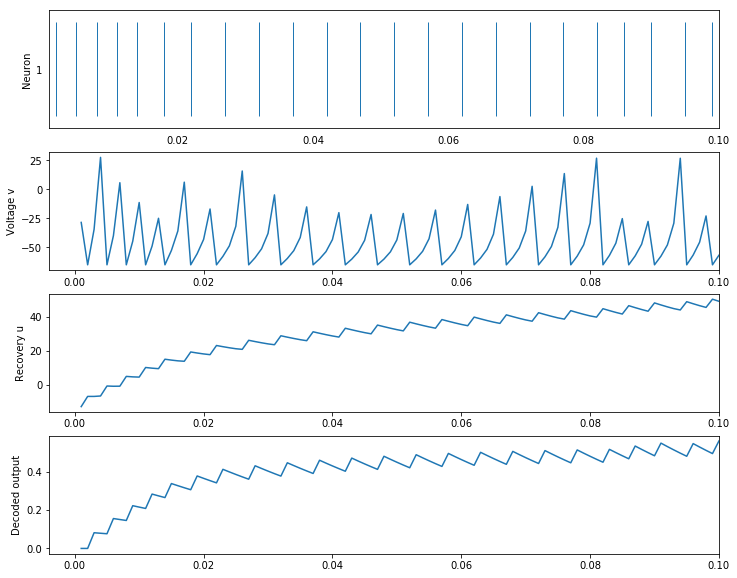

In [486]:
nengo_izh(time=.1)


[docs]class Izhikevich(NeuronType):
    """Izhikevich neuron model.

    This implementation is based on the original paper [1]_;
    however, we rename some variables for clarity.
    What was originally 'v' we term 'voltage', which represents the membrane
    potential of each neuron. What was originally 'u' we term 'recovery',
    which represents membrane recovery, "which accounts for the activation
    of K+ ionic currents and inactivation of Na+ ionic currents."
    The 'a', 'b', 'c', and 'd' parameters are also renamed
    (see the parameters below).

    We use default values that correspond to regular spiking ('RS') neurons.
    For other classes of neurons, set the parameters as follows.

    * Intrinsically bursting (IB): ``reset_voltage=-55, reset_recovery=4``
    * Chattering (CH): ``reset_voltage=-50, reset_recovery=2``
    * Fast spiking (FS): ``tau_recovery=0.1``
    * Low-threshold spiking (LTS): ``coupling=0.25``
    * Resonator (RZ): ``tau_recovery=0.1, coupling=0.26``

    Parameters
    ----------
    tau_recovery : float, optional
        (Originally 'a') Time scale of the recovery variable.
    coupling : float, optional
        (Originally 'b') How sensitive recovery is to subthreshold
        fluctuations of voltage.
    reset_voltage : float, optional
        (Originally 'c') The voltage to reset to after a spike, in millivolts.
    reset_recovery : float, optional
        (Originally 'd') The recovery value to reset to after a spike.

    References
    ----------
    .. [1] E. M. Izhikevich, "Simple model of spiking neurons."
       IEEE Transactions on Neural Networks, vol. 14, no. 6, pp. 1569-1572.
       (http://www.izhikevich.org/publications/spikes.pdf)
    """

    probeable = ("spikes", "voltage", "recovery")

    tau_recovery = NumberParam("tau_recovery", low=0, low_open=True)
    coupling = NumberParam("coupling", low=0)
    reset_voltage = NumberParam("reset_voltage")
    reset_recovery = NumberParam("reset_recovery")

notes on nengo:
They check for spikes and reset the voltage before calculating the recovery variable, because "calculating recovery for voltage values greater than threshold can cause the system to blow up"
* the simulation time can be as long as you want. dt = 0.001 seconds = 1ms


None


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

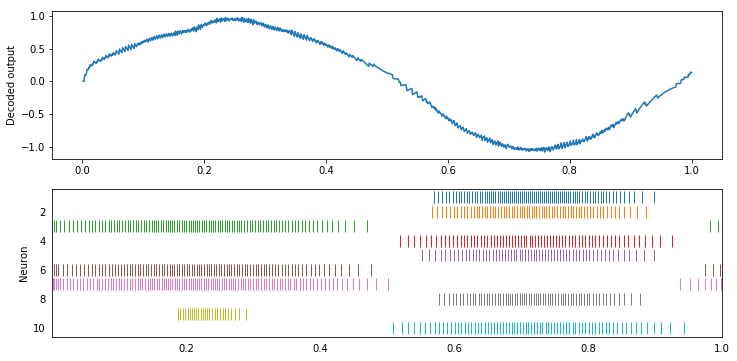

In [487]:
# original example
with nengo.Network(seed=0) as model:

    u = nengo.Node(lambda t: np.sin(2 * np.pi * t))
    ens = nengo.Ensemble(10, dimensions=1, neuron_type=nengo.Izhikevich())
    nengo.Connection(u, ens)
with model:
    out_p = nengo.Probe(ens, synapse=0.03)
    spikes_p = nengo.Probe(ens.neurons)
    voltage_p = nengo.Probe(ens.neurons, 'voltage')
    recovery_p = nengo.Probe(ens.neurons, 'recovery')
    print(ens.noise)
with nengo.Simulator(model) as sim:
    sim.run(1.0)

t = sim.trange()
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, sim.data[out_p])
plt.ylabel("Decoded output")
ax = plt.subplot(2, 1, 2)
rasterplot(t, sim.data[spikes_p], ax=ax)
plt.ylabel("Neuron");

In [154]:
nengo.simulator.Simulator?

Init signature:
nengo.simulator.Simulator(
    network,
    dt=0.001,
    seed=None,
    model=None,
    progress_bar=True,
    optimize=True,
)
Docstring:     
Reference simulator for Nengo models.

The simulator takes a `.Network` and builds internal data structures to
run the model defined by that network. Run the simulator with the
`~.Simulator.run` method, and access probed data through the
``data`` attribute.

Building and running the simulation may allocate resources like files
and sockets. To properly free these resources, call the `.Simulator.close`
method. Alternatively, `.Simulator.close` will automatically be called
if you use the ``with`` syntax:

.. testcode::

   with nengo.Network() as my_network:
       my_ensemble = nengo.Ensemble(10, 1)
       my_probe = nengo.Probe(my_ensemble)

   with nengo.Simulator(my_network) as sim:
       sim.run(0.1)
   print(sim.data[my_probe])

.. testoutput::
   :hide:

   ...

Note that the ``data`` attribute is still accessible even whe

### Multi-neuron model

Now I will try to simulate a network of Izhikevich neurons. What I'm going to be looking for is to see whether the small current noise input will be sufficient for spikes.